**Submission By: Aaryan Verma
(Transfer Learning Model for Vehicle Classification)**

Importing Libraries

In [146]:
import numpy as np
import pandas as pd
import cv2
import time
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from random import shuffle
import glob

In [188]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.models import load_model

Dataset downloaded from: https://www.kaggle.com/rishabkoul1/vechicle-dataset

In [ ]:
!unzip vehicle.zip

In [85]:
path1= glob.glob('vechicles/train/*/*')
path2=glob.glob('vechicles/test/*/*')

In [75]:
classes = { "0": "bike",
"1": "boat",
"2": "bus",
"3": "car",
"4": "cycle",
"5": "helicopter",
"6": "plane",
"7": "scooty",
"8": "truck"}

In [89]:
for i in classes:
  i=classes[i]
  count=0
  for j in glob.glob('vechicles/train/'+i+'/*'):
    count+=1
  print("Images in {} are: {}".format(i,count))

Images in bike are: 48
Images in boat are: 48
Images in bus are: 48
Images in car are: 60
Images in cycle are: 60
Images in helicopter are: 48
Images in plane are: 48
Images in scooty are: 60
Images in truck are: 48


In [ ]:
print(len(path1))
print(len(path2))

468
72


In [ ]:
train_path= 'vechicles/train'
test_path= 'vechicles/test'

In [116]:
img_width,img_height = 128, 128

Downloading Pretrained Model MobileNet V2 for transfer learning

In [181]:
base_model=MobileNetV2(input_shape=[img_width,img_height,3] ,weights='imagenet',include_top=False)

9412608/9406464 [==============================] - 0s 0us/step


In [182]:
for layer in base_model.layers:
    layer.trainable = False

Defining Model Architecture

In [183]:
x=base_model.output
x=GlobalAveragePooling2D()(x)

preds=Dense(9,activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)

model.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
______________________________________________________________________________________

Saving Architecture to JSON for loading weights

In [184]:
json_config = model.to_json()

In [185]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Image Augmentation because of small size of dataset to obtain better accuracy

In [186]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   )

test_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  )

Checkpointer for saving model weights at each loss reduction & earlystopper for stopping the training to avoid overfitting

In [191]:
checkpointer = ModelCheckpoint('best_model.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [189]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (128, 128),
                                                 batch_size = 8,
                                                 class_mode = 'categorical')

Found 468 images belonging to 9 classes.


In [190]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (128, 128),
                                            batch_size = 8,
                                            class_mode = 'categorical')

Found 72 images belonging to 9 classes.


In [192]:
model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  callbacks=[checkpointer, earlystopper]
)

Epoch 1/50
59/59 [==============================] - ETA: 0s - loss: 1.1100 - accuracy: 0.6261
Epoch 00001: val_loss improved from inf to 0.66779, saving model to best_model.hdf5
59/59 [==============================] - 4s 73ms/step - loss: 1.1100 - accuracy: 0.6261 - val_loss: 0.6678 - val_accuracy: 0.7500
Epoch 2/50
58/59 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.9022
Epoch 00002: val_loss improved from 0.66779 to 0.50945, saving model to best_model.hdf5
59/59 [==============================] - 3s 57ms/step - loss: 0.3382 - accuracy: 0.9038 - val_loss: 0.5094 - val_accuracy: 0.8472
Epoch 3/50
58/59 [============================>.] - ETA: 0s - loss: 0.2272 - accuracy: 0.9304
Epoch 00003: val_loss improved from 0.50945 to 0.48654, saving model to best_model.hdf5
59/59 [==============================] - 3s 57ms/step - loss: 0.2261 - accuracy: 0.9316 - val_loss: 0.4865 - val_accuracy: 0.8333
Epoch 4/50
58/59 [============================>.] - ETA: 0s - loss: 

**As we can see Best Model has Training accuracy of 97.22% while Validation accuracy is 83.33%**

Loading Model architecture from JSON

In [193]:
new_model = tf.keras.models.model_from_json(json_config)

Loading Best Weights into Model

In [194]:
new_model.load_weights('best_model.hdf5')

Testing Model on Test Dataset

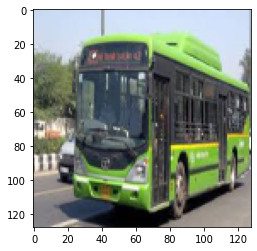

bus


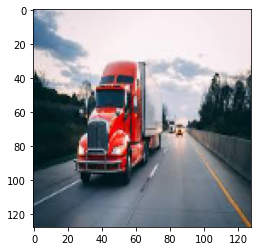

truck


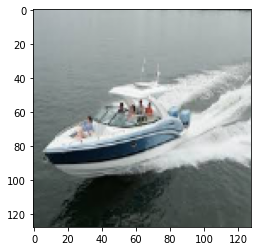

boat


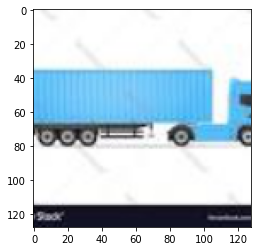

truck


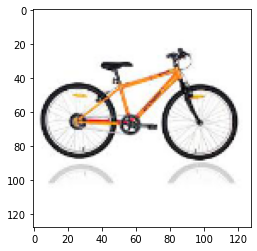

cycle


In [215]:
testing=glob.glob('vechicles/test/*/*')
shuffle(testing)
for img in testing[:5]:
  try:
    img=np.array(Image.open(img))
    img=cv2.resize(img,(128,128))
    plt.imshow(img)
    plt.show()
    img=np.expand_dims(img,axis=0)
    img = preprocess_input(img)
    prediction = new_model.predict(img)
    txt = classes[str(np.argmax(prediction))]
    print(txt)
  except Exception:
    print("Image is not valid")

Saving Whole Model

In [216]:
new_model.save('/content/drive/My Drive/vc_model.h5')